In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import glob
import pandas as pd
# import pygtc
from astropy.io import fits
import astropy.units as u
from uncertainties import ufloat
from scipy.stats import binned_statistic_2d

C:\Users\andre\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
#Importing data from a CSV
#Right click on file, hold 'option', copy as Pathname ez pz
def CSVToDataframe(filepath, verbose=False):
    '''
    Just a really simple function to read in a csv
    '''
    Table=pd.read_csv(filepath)
    if verbose == True:
        print(filepath, 'read in')
    return(Table)

Text(0.6,0.9,'Counts/Beamsize cutoff = 0')

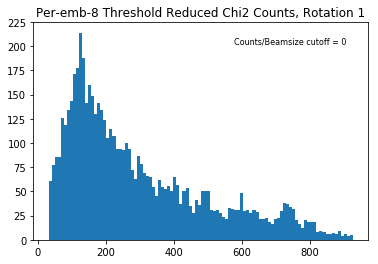

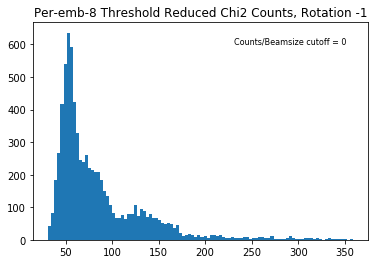

In [3]:
#Histogram of Threshold Reuced Chi2, split by rotation direction
filepath='/Volumes/REU_2023/Per-emb-8_Models/MEGACOMBINED.csv'
ThresholdNumCellsOverBeamAreaThreshold = 0


SourceName=filepath[18:filepath.find('_Models')] #Grabs the sourcename from the filepath. Otherwise replace with sourcename for grph title
Table=CSVToDataframe(filepath)
StatisticallyOKTable=Table.loc[Table['ThresholdNumCellsOverBeamArea'] >= float(ThresholdNumCellsOverBeamAreaThreshold)] #prunes models below our threshold
StatisticallyOKTable=StatisticallyOKTable.reset_index()


PositiveRotationValues=[]
NegativeRotationValues=[]
for i in range(len(StatisticallyOKTable)): #Breaks table up by rotation direction into 2 new tables
    if StatisticallyOKTable['RotationDirection'][i] == 1:
        PositiveRotationValues.append(StatisticallyOKTable['Threshold Reduced Chi2'][i]) #And we only care about 1 variable in the table
        #print(Table['Threshold Reduced Chi2'][i], i)
    else:
        NegativeRotationValues.append(StatisticallyOKTable['Threshold Reduced Chi2'][i])
plt.figure(1) #this could probably be a loop but it didnt start or end up that way
plt.hist(PositiveRotationValues, bins=100)
plt.title(SourceName + ' Threshold Reduced Chi2 Counts, Rotation 1')
plt.annotate(r'Counts/Beamsize cutoff = ' + str(ThresholdNumCellsOverBeamAreaThreshold) , (0.6, 0.9), xycoords='axes fraction', color='k', size=8)
plt.figure(2)
plt.hist(NegativeRotationValues, bins=100)
plt.title(SourceName + ' Threshold Reduced Chi2 Counts, Rotation -1')
plt.annotate(r'Counts/Beamsize cutoff = ' + str(ThresholdNumCellsOverBeamAreaThreshold) , (0.6, 0.9), xycoords='axes fraction', color='k', size=8)
#print(PositiveRotationValues, NegativeRotationValues)


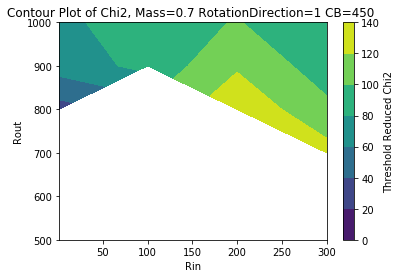

In [4]:
#Contour Plot of 2 independant variables, 1 dependant variable
ThresholdNumCellsOverBeamAreaThreshold = 6
#Lets import our Table, change the filepath to match on your end
#Should be to the csv I provide in google docs
Table=CSVToDataframe('/Volumes/REU_2023/Per-emb-14_Models/PerEmb14CenterCSV.csv')
StatisticallyOKTable=Table.loc[Table['ThresholdNumCellsOverBeamArea'] >= float(ThresholdNumCellsOverBeamAreaThreshold)] 
StatisticallyOKTable=StatisticallyOKTable.reset_index()
#Setting up how we want to set our axis for contours

#Set these equal to the strings of table headers desired
XAxis='Rin'
YAxis='Rout'
ZAxis='Threshold Reduced Chi2'

#Setting up conditionals, store in 2 parts: Column, Value
#All as strings
#Because a countour plot only has 2 independant variables, we need to assume some stuff as constants
Conditional1=['Mass', '0.7']
Conditional2=['RotationDirection', '1']
Conditional3=['CB', '450']

#Here be code, don't change stuff here
#First, find table index values that match the conditionals set
#This goes per conditional, so we will find the ones that are all 3 next
Condition1=StatisticallyOKTable.loc[StatisticallyOKTable[Conditional1[0]] == float(Conditional1[1])] 
Condition2=StatisticallyOKTable.loc[StatisticallyOKTable[Conditional2[0]] == float(Conditional2[1])]
Condition3=StatisticallyOKTable.loc[StatisticallyOKTable[Conditional3[0]] == float(Conditional3[1])]
#Find the ones that match across all conditionals
temp=np.intersect1d(Condition1.index, Condition2.index)
Final=(np.intersect1d(temp, Condition3.index))
#print(Final)
#Now we have a list of indexes that match all 3 of our conditionals

XList=[]
YList=[]
ZList=[]
for i in range(len(Final)): #This goes through the list of indexes we found, and extracts the X, Y and Z data from those indexes
    #print(Table[XAxis][i], Table[YAxis][i], Table[ZAxis][i])
    XList.append(StatisticallyOKTable[XAxis][Final[i]])
    YList.append(StatisticallyOKTable[YAxis][Final[i]])
    ZList.append(StatisticallyOKTable[ZAxis][Final[i]])
XGrid, YGrid = np.meshgrid(np.sort(np.unique(XList)), np.unique(YList)) #Formats the X and Y axis to plt.contour wants

ZGrid=np.full_like(XGrid, np.nan, dtype=np.float64) #Makes an empty array, same shape as XGrid, filled with nan values
for xi, yi, zi in zip(XList, YList, ZList): #This is going to go down the ZList, and insert the value into the empty ZGrid in the correct spot
#     print(type(int(xi)))
    tempx=np.where(int(xi) == np.asarray(np.unique(XGrid), dtype='int'))[0][0] #These 2 steps find the index coordinates we need to put zi in
    tempy=np.where(int(yi) == np.asarray(np.unique(YGrid), dtype='int'))[0][0]
#     print(tempx, tempy)
    ZGrid[tempy][tempx] = zi #And inserting it into the spot that matches up on XGrid and YGrid
#print(XGrid, YGrid, ZGrid)

Plot=plt.contourf(XGrid, YGrid, ZGrid) #And lastly our contour plot maker
plt.xlabel(XAxis)
plt.ylabel(YAxis)
cbar = plt.colorbar(Plot)
cbar.set_label(ZAxis, rotation=90)
plt.title('Contour Plot of Chi2, ' 
          + str(Conditional1[0]) + '=' + Conditional1[1] + ' '
          + str(Conditional2[0]) + '=' + Conditional2[1] + ' '
          + str(Conditional3[0]) + '=' + Conditional3[1] + ' ')
plt.show()

In [4]:
def ListUpdater(XAxis, YAxis, RotationDirection, Table, ZAxis = 'Threshold Reduced Chi2'):
    #Take care of RotationDirection
    RotationTable = Table[Table['RotationDirection'] == RotationDirection]
    return( 
        RotationTable[XAxis].tolist(), #nice function
        RotationTable[YAxis].tolist(), #before I was looping over entries and appending them to a new list
        RotationTable[ZAxis].tolist()
        )

In [4]:
# Per-emb-14 : Color Min/Max = 10/30
# Per-emb-30 : Color Min/Max = 10/30
# Per-emb-8 : Color Min/Max = 40/60
# Per-emb-62 : Color Min/Max = 0/10
# SVS13C : Color Min/Max = 0/10
# HH211 : Color Min/Max = 100/125
# SVS13B : Color Min/Max = 10/30
# B5IRS1 : Color Min/Max = 0/20
# Per-emb-50 : Color Min/Max = 0/5
# IC348_MMS

<ipython-input-9-59bd21512762>:180: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar=fig.colorbar(Plot, cax=cax, cmap=cmap, ticks = [colorbarmin, colorbarmax, 0, 1, 5, 10, 20, 30, 40, 50, 100, 200])


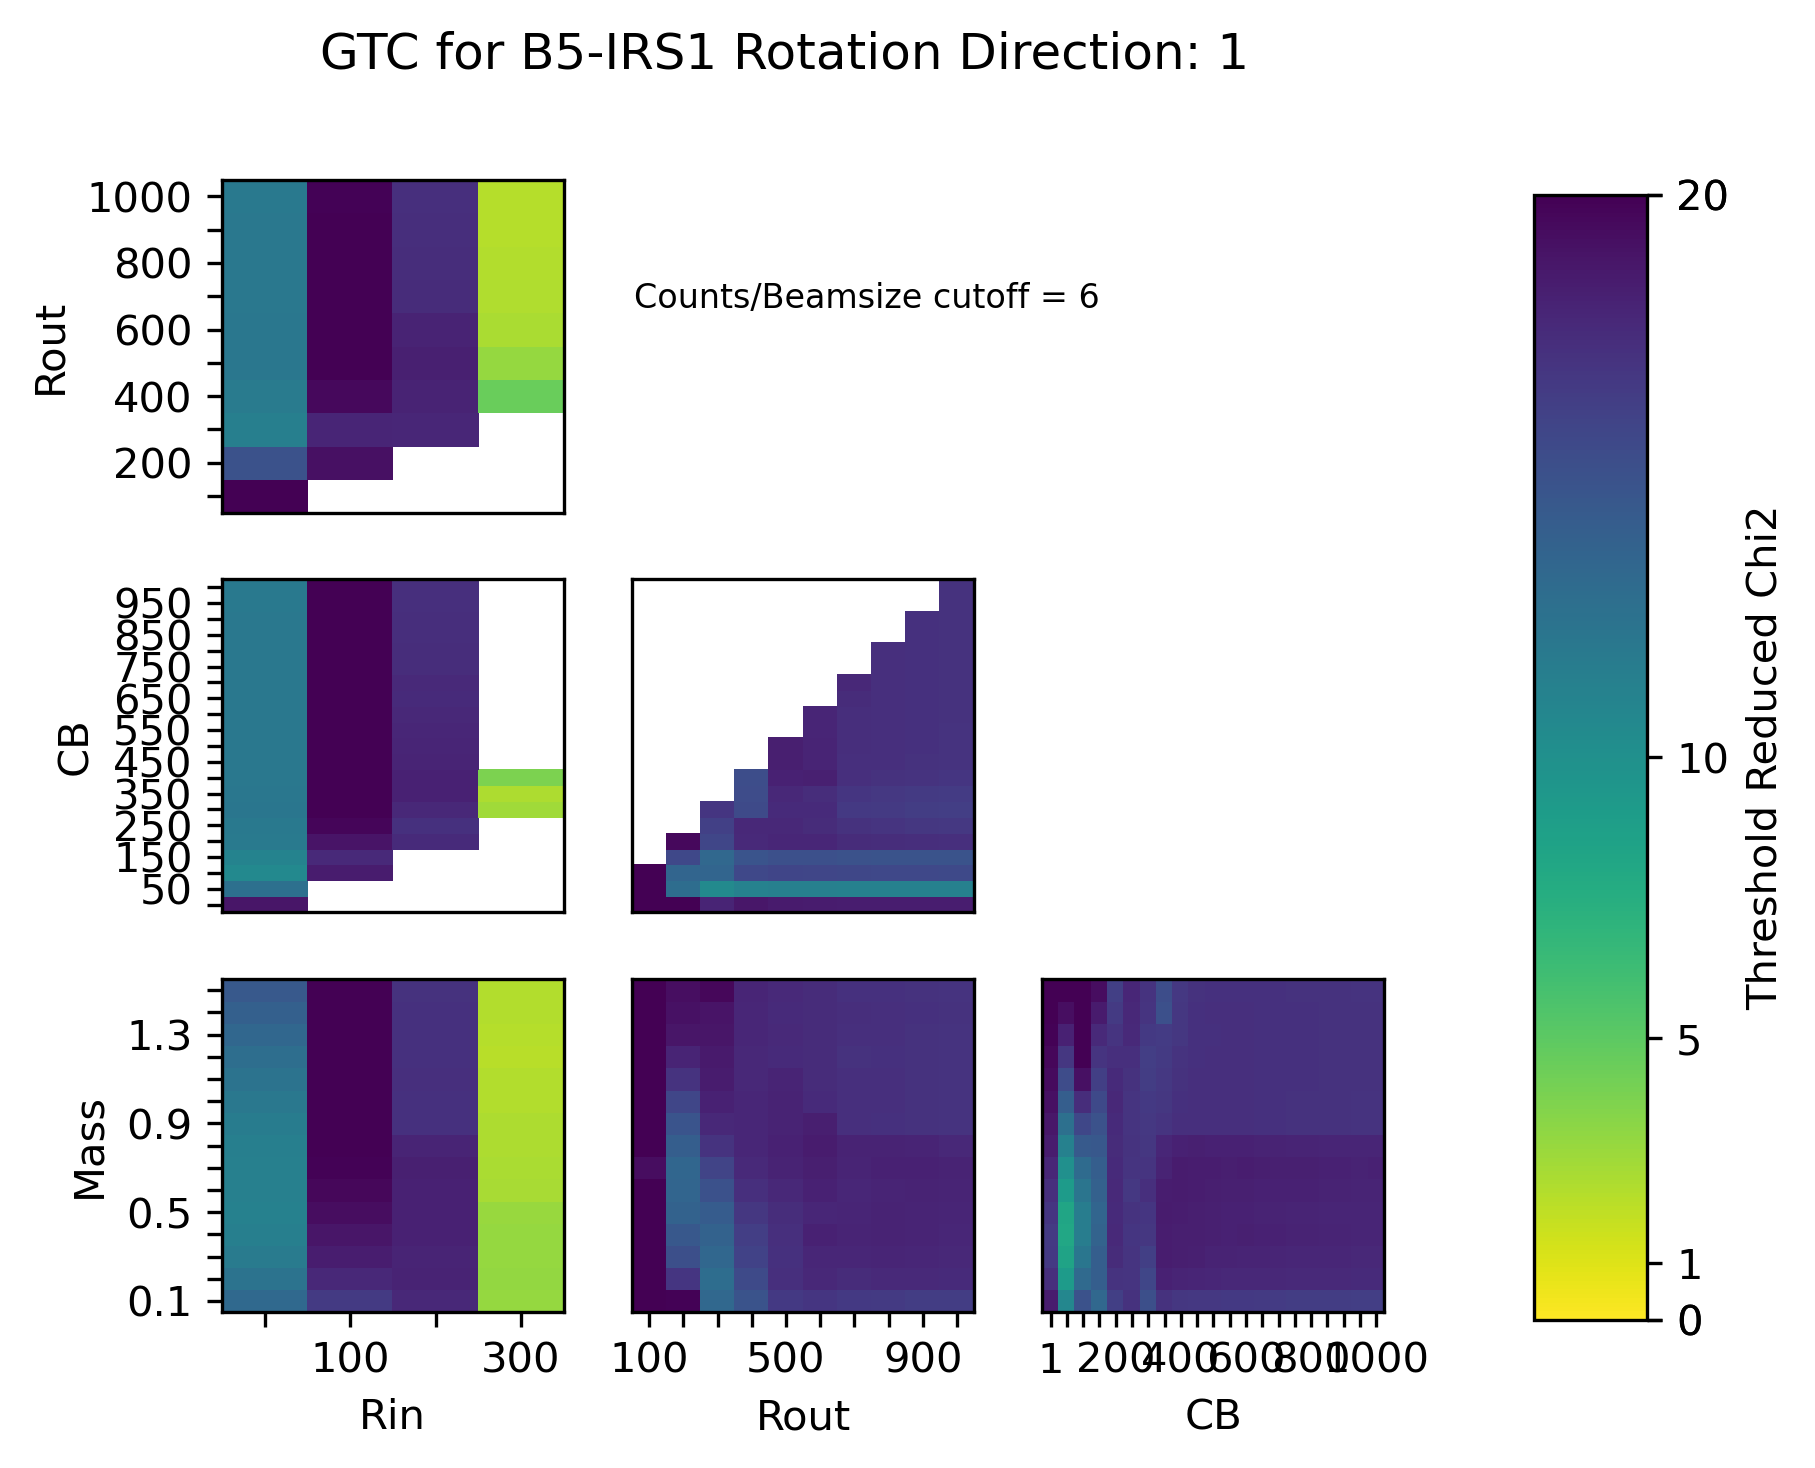

In [9]:
#Big Triangle
#Read in Table
Table = CSVToDataframe('B5-IRS1_NewBatch.csv')
ObjectName='B5-IRS1'
RotationDirections = [1]
#Define our parameters
Param1='Rin'
Param2='Rout'
Param3='CB'
Param4='Mass'
ThresholdNumCellsOverBeamAreaThreshold = 6
colorbarmin=0
colorbarmax=20
ZAxis='Threshold Reduced Chi2'
cmap='viridis_r'
#USER INPUTS END

StatisticallyOKTable=Table.loc[Table['ThresholdNumCellsOverBeamArea'] >= float(ThresholdNumCellsOverBeamAreaThreshold)] 
StatisticallyOKTable.reindex() #This takes care of our threshold value, only keeps good models

#This part makes the global colorbar. Surely there is a better way to do this though
XList, YList, ZList = ListUpdater(Param1, Param2, 1, StatisticallyOKTable) 
Plot=plt.scatter(XList, YList, c=ZList, cmap=cmap, vmin=colorbarmin, vmax=colorbarmax) 
plt.close()


for i in range(len(RotationDirections)):
    #Setup Subplots
    fig = plt.figure(figsize=(5, 5), dpi = 300)

    #Prepare for code mess below! Lots of small but significant changes on a subpllot by subplot basis so no easy loop
#================================================================================================    
    # Create subplot
    sub1 = fig.add_subplot(331)
    # Prepare data
#     XList2, YList2, ZList2 = ListUpdater(Param1, Param3, RotationDirections[i], StatisticallyOKTable)
    XList, YList, ZList = ListUpdater(Param1, Param2, RotationDirections[i], StatisticallyOKTable)
    # Bin data
    stat, xedges, yedges, binnumber = binned_statistic_2d(
        XList, YList, ZList, statistic='median',
        bins=(len(np.unique(XList)), len(np.unique(YList)))
    )
    # Plot
    sub1.pcolor(stat.T, cmap=cmap, vmin=colorbarmin, vmax=colorbarmax)
    # Axis formatting
    sub1.set_xticks([]) #Disable xticks for this subplot
    sub1.set_yticks((np.linspace(0, len(np.unique(YList))-1, len(np.unique(YList)))+0.5)) #set units on y
    #We want to make a list of strings, where empty ones represent minor ticks without units
    YLabels=[]
    for j in range(len(np.unique(YList))):
        if j%2==0:
            YLabels.append('')
        else:
            YLabels.append(np.unique(YList)[j])
    sub1.set_yticklabels(YLabels)
    sub1.set_ylabel(Param2)
#================================================================================================
    # Create subplot
    sub4 = fig.add_subplot(334)
    # Prepare data
    XList, YList, ZList = ListUpdater(Param1, Param3, RotationDirections[i], StatisticallyOKTable)
    # Bin data
    stat, xedges, yedges, binnumber = binned_statistic_2d(
        XList, YList, ZList, statistic='median',
        bins=(len(np.unique(XList)), len(np.unique(YList)))
    )
    # Plot
    sub4.pcolor(stat.T, cmap=cmap, vmin=colorbarmin, vmax=colorbarmax)
    # Axis formatting
    sub4.set_xticks([]) #Disable xticks for this subplot
    sub4.set_yticks((np.linspace(0, len(np.unique(YList))-1, len(np.unique(YList)))+0.5)) #set units on y
    #We want to make a list of strings, where empty ones represent minor ticks without units
    YLabels=[]
    for j in range(len(np.unique(YList))):
        if j%2==0:
            YLabels.append('')
        else:
            YLabels.append(np.unique(YList)[j])
    sub4.set_yticklabels(YLabels)
    sub4.set_ylabel(Param3)
#================================================================================================
    # Create subplot
    sub5 = fig.add_subplot(335)
    # Prepare data
    XList, YList, ZList = ListUpdater(Param2, Param3, RotationDirections[i], StatisticallyOKTable)
    # Bin data
    stat, xedges, yedges, binnumber = binned_statistic_2d(
        XList, YList, ZList, statistic='median',
        bins=(len(np.unique(XList)), len(np.unique(YList)))
    )
    # Plot
    sub5.pcolor(stat.T, cmap=cmap, vmin=colorbarmin, vmax=colorbarmax)
    # Axis formatting
    sub5.set_xticks([]) #Disable xticks for this subplot
    sub5.set_yticks([]) #And the yticks too
#================================================================================================
    # Create subplot
    sub7 = fig.add_subplot(337)
    # Prepare data
    XList, YList, ZList = ListUpdater(Param1, Param4, RotationDirections[i], StatisticallyOKTable)
    # Bin data
    stat, xedges, yedges, binnumber = binned_statistic_2d(
        XList, YList, ZList, statistic='median',
        bins=(len(np.unique(XList)), len(np.unique(YList)))
    )
    # Plot
    sub7.pcolor(stat.T, cmap=cmap, vmin=colorbarmin, vmax=colorbarmax)
    # Axis formatting
    sub7.set_xticks((np.linspace(0, len(np.unique(XList))-1, len(np.unique(XList)))+0.5)) #set units on X
    #We want to make a list of strings, where empty ones represent minor ticks without units
    XLabels=[]
    for j in range(len(np.unique(XList))):
        if j%2==0:
            XLabels.append('')
        else:
            XLabels.append(np.unique(XList)[j])
    sub7.set_xticklabels(XLabels)
    sub7.set_xlabel(Param1)

    sub7.set_yticks((np.linspace(0, len(np.unique(YList))-1, len(np.unique(YList)))+0.5)) #set units on y
    #We want to make a list of strings, where empty ones represent minor ticks without units
    YLabels=[]
    for j in range(len(np.unique(YList))):
        if j%4!=0:
            YLabels.append('')
        else:
            YLabels.append(np.unique(YList)[j])
    sub7.set_yticklabels(YLabels)
    sub7.set_ylabel(Param4)
#================================================================================================
    # Create subplot
    sub8 = fig.add_subplot(338)
    # Prepare data
    XList, YList, ZList = ListUpdater(Param2, Param4, RotationDirections[i], StatisticallyOKTable)
    # Bin data
    stat, xedges, yedges, binnumber = binned_statistic_2d(
        XList, YList, ZList, statistic='median',
        bins=(len(np.unique(XList)), len(np.unique(YList)))
    )
    # Plot
    sub8.pcolor(stat.T, cmap=cmap, vmin=colorbarmin, vmax=colorbarmax)
    # Axis formatting
    sub8.set_xticks((np.linspace(0, len(np.unique(XList))-1, len(np.unique(XList)))+0.5)) #set units on X
    #We want to make a list of strings, where empty ones represent minor ticks without units
    XLabels=[]
    for j in range(len(np.unique(XList))):
        if j%4!=0:
            XLabels.append('')
        else:
            XLabels.append(np.unique(XList)[j])
    sub8.set_xticklabels(XLabels)
    sub8.set_xlabel(Param2)
    sub8.set_yticks([])
#================================================================================================
    # Create subplot
    sub9 = fig.add_subplot(339)
    # Prepare data
    XList, YList, ZList = ListUpdater(Param3, Param4, RotationDirections[i], StatisticallyOKTable)
    # Bin data
    stat, xedges, yedges, binnumber = binned_statistic_2d(
        XList, YList, ZList, statistic='median',
        bins=(len(np.unique(XList)), len(np.unique(YList)))
    )
    # Plot
    sub9.pcolor(stat.T, cmap=cmap, vmin=colorbarmin, vmax=colorbarmax)
    # Axis formatting
    sub9.set_xticks((np.linspace(0, len(np.unique(XList))-1, len(np.unique(XList)))+0.5)) #set units on X
    #We want to make a list of strings, where empty ones represent minor ticks without units
    XLabels=[]
    for j in range(len(np.unique(XList))):
        if j%4==0:
            XLabels.append(np.unique(XList)[j])
        else:
            XLabels.append('')
    sub9.set_xticklabels(XLabels)
    sub9.set_xlabel(Param3)
    sub9.set_yticks([])
#================================================================================================
    cax = plt.axes([1, 0.12, 0.075, .75])
    cbar=fig.colorbar(Plot, cax=cax, cmap=cmap, ticks = [colorbarmin, colorbarmax, 0, 1, 5, 10, 20, 30, 40, 50, 100, 200])
    cax.annotate(r'Counts/Beamsize cutoff = ' + str(ThresholdNumCellsOverBeamAreaThreshold) , (-8, 0.9), xycoords='axes fraction', color='k', size=8)
#     ticks = [5, 7.5, 10, 12.5]
#     fig.colorbar(cm.ScalarMappable(), ax=cax) 
    cbar.set_label(ZAxis)
#     cbar.set_cmap('summer')

    plt.suptitle('GTC for '+ObjectName + ' Rotation Direction: '+str(RotationDirections[i]))
    plt.show()
    fig.savefig(ObjectName + ' GTC Rotation=' + str(RotationDirections[i]), dpi = 'figure')

In [3]:
def BestModels(CSV, BeamAreaThreshold, Chi2Extra, verbose=True):
    #Taking in CSV and fit params, spits out filenames of best remaining models, one per rotation direction
    #Cutting Board
    #Takes in the big Table from the CSV, chops off bad models
    Table = CSVToDataframe(CSV)

    #Pruning Bad Models
    BetterTable=Table.loc[Table['ThresholdNumCellsOverBeamArea'] >= float(BeamAreaThreshold)] 
    BetterTable.reindex()
    BestChi2=np.min(BetterTable['Threshold Reduced Chi2'])
    BetterTable=BetterTable.loc[BetterTable['Threshold Reduced Chi2'] <= (1+Chi2Extra)*BestChi2] 
    BetterTable.reindex()
    
    Positives=BetterTable.loc[BetterTable['RotationDirection'] == 1] 
#     Negatives=BetterTable.loc[BetterTable['RotationDirection'] == -1]
    BestChi2Positive=np.min(Positives['Threshold Reduced Chi2'])
#     BestChi2Negative=np.min(Negatives['Threshold Reduced Chi2'])
    
#     NegativeName=Negatives.loc[Negatives['Threshold Reduced Chi2'] == BestChi2Negative]
    #return(NegativeName['Cube Name'])
    PositiveName=Positives.loc[Positives['Threshold Reduced Chi2'] == BestChi2Positive]
    return(PositiveName['Cube Name'])
#            , NegativeName['Cube Name'])
    #return(BestChi2Positive, BestChi2Negative)
    

<ipython-input-35-6c4104c2d9bb>:116: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor = ax.pcolor(offset.value, vel.value, pvdata, norm=norm, cmap='Blues') # plot the data in color


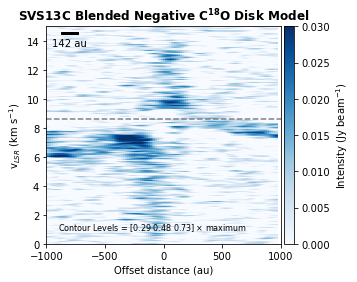

In [35]:
# Script for position-velcity plots with a Keplerian profile overlaid

###### import necessary python packages and modules
import numpy as np  #this is a package (all of numpy)
import astropy.units as u  #this is a module (units from within astropy)
import matplotlib.pyplot as plt
from astropy.constants import G
from astropy.wcs import WCS
from astropy.io import fits
from astropy.visualization import simple_norm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

###################################################
########## BEGIN USER INPUTS
inputfile = 'ProtostarALMA/Per-Emb-50_C18O_PV_slice_natural_vel_subcube.fits'
inputfile_model = 'ProtostarBestPV/SVS13C/Negative/SVS13CBlendedPV.fits'
outplotname = 'SVS13CBlendedNegative.png'
plottitle = r'SVS13C Blended Negative C$^{\mathbf{18}}$O Disk Model'

#### information from the image
rms = 5.0e-3 # noise level in Jy/beam

#### parameters we fit for
v_lsr = 8.63 * u.km/u.s  # v0, velocity offset from Keplerian fit
r0 =  0 * u.au  # r0, radial offset from Keplerian fit
source_dist = 300  # distance in parsec, used for unit conversion later

#### some plotting options
# axes ranges
ylim = [0, 15] #km/s
xlim = [-1000, 1000] #au

# plotting color bar
vmin = 0.0 #Jy/beam, minimum plotting intensity
vmax = 0.03 #Jy/beam, maximum plotting flux

ContourLines=np.array([.3, .5, .75])

######## END USER INPUTS
##########################################################


##########################
# Read in the data
pvdata = fits.getdata(inputfile)
pvhead = fits.getheader(inputfile)

# get some values from the header
d_npix = pvhead['NAXIS1']
v_npix = pvhead['NAXIS2']
d0 = pvhead['CRVAL1']
v0 = pvhead['CRVAL2']
delta_d = pvhead['CDELT1']
delta_v = pvhead['CDELT2']
d_pix0 = pvhead['CRPIX1']
v_pix0 = pvhead['CRPIX2']
bmaj = pvhead['BMAJ']
bmin = pvhead['BMIN']

# convert the data to two 1D arrays for offset and distance using the header info
d_arr = np.array([d0 + delta_d * (i - d_pix0) for i in range(d_npix)]) * 3600 * u.arcsec
v_arr = np.array([v0 + delta_v * (i - v_pix0) for i in range(v_npix)]) / 1000 * u.km/u.s

# transformation to au, correct for r0 re-centering
center_d = d_arr[int(len(d_arr)/2 + 1)]
d_offset_arr = (d_arr - center_d)
d_offset_arr_au = d_offset_arr.value * source_dist * u.au + r0 

# create the 2D final array from the km/s and au 1D arrays
offset, vel = np.meshgrid(d_offset_arr_au, v_arr)


##########################
# Read in the model
pvdata_m = fits.getdata(inputfile_model)
pvhead_m = fits.getheader(inputfile_model)

# get some values from the header
d_npix_m = pvhead_m['NAXIS1']
v_npix_m = pvhead_m['NAXIS2']
d0_m = pvhead_m['CRVAL1']
v0_m = pvhead_m['CRVAL2']
delta_d_m = pvhead_m['CDELT1']
delta_v_m = pvhead_m['CDELT2']
d_pix0_m = pvhead_m['CRPIX1']
v_pix0_m = pvhead_m['CRPIX2']
bmaj_m = pvhead_m['BMAJ']
bmin_m = pvhead_m['BMIN']

# convert the data to two 1D arrays for offset and distance using the header info
d_arr_m = np.array([d0_m + delta_d_m * (i - d_pix0_m) for i in range(d_npix_m)]) * 3600 * u.arcsec
v_arr_m = np.array([v0_m + delta_v_m * (i - v_pix0_m) for i in range(v_npix_m)]) / 1000 * u.km/u.s

#contour levels to be plotted
#contourlevels = np.array([4, 8, 16]) * rms #Old method
contourlevels=np.round(ContourLines * np.max(pvdata_m), decimals = 2) #New method


# transformation to au, correct for r0 re-centering
center_d_m = d_arr_m[int(len(d_arr_m)/2 + 1)]
d_offset_arr_m = (d_arr_m - center_d_m)
d_offset_arr_au_m = d_offset_arr_m.value * source_dist * u.au + r0 

# create the 2D final array from the km/s and au 1D arrays
offset_m, vel_m = np.meshgrid(d_offset_arr_au_m, v_arr_m)

##########################
##########################
# define some basic plotting parameters
fig = plt.figure(figsize=(5,4)) # figsize is in inches
ax = fig.add_subplot(111)

# plot intensities in color
norm = simple_norm(pvdata, 'linear', min_cut=vmin,max_cut=vmax) # Normalization of data, using user input
pcolor = ax.pcolor(offset.value, vel.value, pvdata, norm=norm, cmap='Blues') # plot the data in color
pcolor.set_edgecolor('face') # remove default white gridlines

# plot the contours
#contours = ax.contour(offset_m.value, vel_m.value, pvdata_m, contourlevels, colors='darkorange',linewidths=2)

# add a colorbar, with units and label
fig.colorbar(pcolor, ax=ax,label=r'Intensity (Jy beam$^{-1}$)',pad=0.01) 

###### set x and y limits
ax.set_ylim(ylim)
ax.set_xlim(xlim)

###### add some annotations to the plot
ax.axhline(v_lsr.value,color='grey', linestyle='--',lw=1.5) # horizontal line for v_lsr

###### add some labels
ax.set_ylabel(r'v$_{LSR}$ (km s$^{-1}$)')
ax.set_xlabel('Offset distance (au)')
ax.annotate(r'Contour Levels = ' + str(contourlevels) +  r' $\times$ maximum', (0.05, 0.06), xycoords='axes fraction', color='k', size=8)
ax.set_title(plottitle, size=12, weight='bold',color='black')

###### add a scale bar showing the size of the beam in au
beam_arcsec = ((bmaj + bmin) / 2) * 3600 # average beam size, in arcsec
beam_au = beam_arcsec * source_dist # beamsize in au
beam = "{:.0f}".format(beam_au) # remove decimal points in label
fontprops = fm.FontProperties(size=10) # scale bar label size
bar = AnchoredSizeBar(ax.transData, beam_au, beam + ' au', 2,pad=0.1, borderpad=0.5, sep=5,  frameon=False, color='k', size_vertical=0.08, fontproperties=fontprops)
ax.add_artist(bar)

###### save the figure
fig.savefig(outplotname, dpi=300, bbox_inches='tight')

In [19]:
#Reportables Function
def Reportables(CSV, BeamAreaThreshold, Chi2Extra, verbose=True):
    
    '''
    This function looks at the CSV provided, and computes the reportable numbers for the Mass, Rin, Rout, CB.
    This also handles uncertianties for thoe values.
    To find a value, it prunes the table to entries with a BeamareaRatio > the threshold, finds the best chi2 remaining,
    takes all entries with a threshold chi2 based on that best--with a small extra factor to include only the models within
    a % of the min.
    To report a value, it averages the remaining entries' values
    To report an uncertianty, it returns the stanard deviation of that value in the table
    
    Inputs:
    CSV--A string filepath to the csv. In my case something like '/Volumes/REU_2023/Per-emb-14_Models/Position_Velocity_Per-emb-14_C18O.fits'
    BeamAreaThreshold--A float or int threshold value for the Beam Area Ratio. Entries with a value less than the threshold are removed
    Chi2Extra--A float or int value, takes the cutoff chi2 value as a (1+Chi2Extra)*BestChi2 to allow more entries in
    
    Outputs:
    Working on getting the uncertianties package, would make this a lot easier lol
    '''

    #Cutting Board
    #Takes in the big Table from the CSV, chops off bad models
    Table = CSVToDataframe(CSV)

    #END

    #Pruning Bad Models
    BetterTable=Table.loc[Table['ThresholdNumCellsOverBeamArea'] >= float(BeamAreaThreshold)] 
    BetterTable.reindex()
    BestChi2=np.min(BetterTable['Threshold Reduced Chi2'])
    BetterTable=BetterTable.loc[BetterTable['Threshold Reduced Chi2'] <= (1+Chi2Extra)*BestChi2] 
    BetterTable.reindex()
    #print(len(StatisticallyOKTable))

    Positives=BetterTable.loc[BetterTable['RotationDirection'] == 1] 
    Negatives=BetterTable.loc[BetterTable['RotationDirection'] == -1]

    PositiveMass=np.average(Positives['Mass'])
    PositiveMassUncertianty=np.std(Positives['Mass'])
    PositiveRin=np.average(Positives['Rin'])
    PositiveRinUncertianty=np.std(Positives['Rin'])
    PositiveRout=np.average(Positives['Rout'])
    PositiveRoutUncertianty=np.std(Positives['Rout'])
    PositiveCB=np.average(Positives['CB'])
    PositiveCBUncertianty=np.std(Positives['CB'])

    NegativeMass=np.average(Negatives['Mass'])
    NegativeMassUncertianty=np.std(Negatives['Mass'])
    NegativeRin=np.average(Negatives['Rin'])
    NegativeRinUncertianty=np.std(Negatives['Rin'])
    NegativeRout=np.average(Negatives['Rout'])
    NegativeRoutUncertianty=np.std(Negatives['Rout'])
    NegativeCB=np.average(Negatives['CB'])
    NegativeCBUncertianty=np.std(Negatives['CB'])
    
    if verbose == True:
        # Format string
        fmt = f".{4}uS"  # 'uS' ensures proper formatting of uncertainties
        print('Best Chi2:', f"{BestChi2:.{4}f}")  # Regular float formatting
        print('Chi2 Bonus:', Chi2Extra)
        print('So we are allowing models with chi2 less than:', (1+Chi2Extra) * BestChi2)
        print('With a BeamAreaThreshold over:', BeamAreaThreshold)
        print('---------------------------------------------')
        print('Negative Models Used:', len(Negatives))
        print('    Negatives Keplerian Models:', np.sum(Negatives['Keplerian?']))
        print('    Negatives IRE Models:', np.sum(Negatives['IRE?']))
        print('    Negatives Blended Models:', np.sum(Negatives['Blended?']))
        print("")
        print('Negative Mass:', format(ufloat(NegativeMass, NegativeMassUncertianty)))
        print('Negative Rout:', format(ufloat(NegativeRout, NegativeRoutUncertianty), fmt))
        print('Negative Rin:', format(ufloat(NegativeRin, NegativeRinUncertianty), fmt))
        print('Negative CB:', format(ufloat(NegativeCB, NegativeCBUncertianty), fmt))
        print('---------------------------------------------')
        print('Positive Models Used:', len(Positives))
        print('    Positives Keplerian Models:', np.sum(Positives['Keplerian?']))
        print('    Positives IRE Models:', np.sum(Positives['IRE?']))
        print('    Positives Blended Models:', np.sum(Positives['Blended?']))
        print("")
        print('Positive Mass:', format(ufloat(PositiveMass, PositiveMassUncertianty)))
        print('Positive Rout:', format(ufloat(PositiveRout, PositiveRoutUncertianty), fmt))
        print('Positive Rin:', format(ufloat(PositiveRin, PositiveRinUncertianty), fmt))
        print('Positive CB:', format(ufloat(PositiveCB, PositiveCBUncertianty), fmt))
        
#         print('Positive Mass:', ufloat(PositiveMass, PositiveMassUncertianty))
#         print('Positive Rout:', ufloat(PositiveRout, PositiveRoutUncertianty))
#         print('Positive Rin:', ufloat(PositiveRin, PositiveRinUncertianty))
#         print('Positive CB:', ufloat(PositiveCB, PositiveCBUncertianty))
#         print("")
#         print('Negative Mass:', ufloat(NegativeMass, NegativeMassUncertianty))
#         print('Negative Rout:', ufloat(NegativeRout, NegativeRoutUncertianty))
#         print('Negative Rin:',  ufloat(NegativeRin, NegativeRinUncertianty))
#         print('Negative CB:',  ufloat(NegativeCB, NegativeCBUncertianty))
#         print("")
#         print('Best Chi2:', BestChi2)

    return(
           ufloat(PositiveMass, PositiveMassUncertianty), 
           ufloat(PositiveRout, PositiveRoutUncertianty), 
           ufloat(PositiveRin, PositiveRinUncertianty), 
           ufloat(PositiveCB, PositiveCBUncertianty), 
           ufloat(NegativeMass, NegativeMassUncertianty), 
           ufloat(NegativeRout, NegativeRoutUncertianty), 
           ufloat(NegativeRin, NegativeRinUncertianty), 
           ufloat(NegativeCB, NegativeCBUncertianty), 
           BestChi2
          )

In [30]:
# glob.glob('Per-emb-14.c*')
Reportables('ProtostarDataCSV/B5IRS1.csv', 6, 1)

#Seperate out models by IRE, KEP, Blended

Best Chi2: 2.7706
---------------------------------------------
Negative Models Used: 0
    Negatives Keplerian Models: 0
    Negatives IRE Models: 0
    Negatives Blended Models: 0

Negative Mass: nan+/-nan
Negative Rout:  nan(nan)
Negative Rin:  nan(nan)
Negative CB:  nan(nan)
---------------------------------------------
Positive Models Used: 42
    Positives Keplerian Models: 14
    Positives IRE Models: 15
    Positives Blended Models: 13

Positive Mass: 0.8+/-0.4
Positive Rout: 400.0(0)
Positive Rin: 300.0(0)
Positive CB: 348.81(41.53)


C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(0.8404761904761904+/-0.4180792382229792,
 400.0+/-0,
 300.0+/-0,
 348.8095238095238+/-41.5303893869343,
 nan+/-nan,
 nan+/-nan,
 nan+/-nan,
 nan+/-nan,
 2.7706)

In [11]:
PositiveBestModel=BestModels('B5-IRS1_NewBatch.csv', 6, .2)[0].values[0]
NegativeBestModel=BestModels('B5-IRS1_NewBatch.csv', 6, 2)[1].values[0]

print(PositiveBestModel[:-5])
print(NegativeBestModel[:-5])

IC348_MMS-Vsys8.76_LineC18O_21_Pix0.054as-0.041666787141436kmps_D300M1.5CB300.I44PA77Rot1Rout1000.Rin300._IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW0.97_Beam0.559x0.394PA-9.44
IC348_MMS-Vsys8.76_LineC18O_21_Pix0.054as-0.041666787141436kmps_D300M0.1CB100.I44PA77Rot-1Rout200.Rin1._IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW0.97_Beam0.559x0.394PA-9.44


Diagnostic Plots, Some extra tools to justify some number choices

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_

C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_

C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_

C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_

C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_

C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_

C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

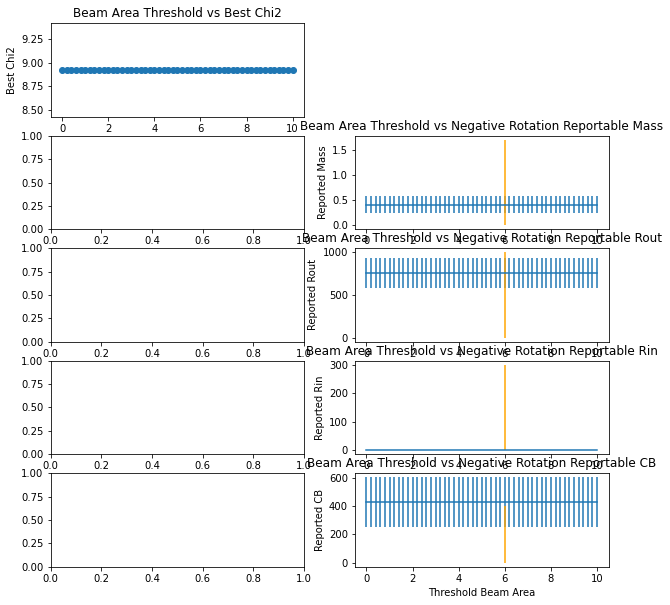

In [201]:
#Beam Area Ratio vs Best Chi2 check
#this is chinky code, takes a very hot minute to run
filename='Per-emb-14.csv'
Chi2Bonus=.25


#DONE
fig = plt.figure(figsize=(10, 10)) #Setup all the subplots
sub1 = fig.add_subplot(521)
sub3 = fig.add_subplot(523)
sub4 = fig.add_subplot(524)
sub5 = fig.add_subplot(525)
sub6 = fig.add_subplot(526)
sub7 = fig.add_subplot(527)
sub8 = fig.add_subplot(528)
sub9 = fig.add_subplot(529)
sub10 = fig.add_subplot(5, 2, 10)

XAxis=np.linspace(0, 10, 51) #Setup the ThresholdBeamAreaRatio tests

YAxisChi2=[] #omg lots of variables
YAxisPosMass=[]
YAxisErrPosMass=[]
YAxisNegMass=[]
YAxisErrNegMass=[]
YAxisPosRout=[]
YAxisErrPosRout=[]
YAxisNegRout=[]
YAxisErrNegRout=[]
YAxisPosRin=[]
YAxisErrPosRin=[]
YAxisNegRin=[]
YAxisErrNegRin=[]
YAxisPosCB=[]
YAxisErrPosCB=[]
YAxisNegCB=[]
YAxisErrNegCB=[]

for i in XAxis:
    YAxisChi2.append(Reportables(filename, i, Chi2Bonus, verbose=False)[8])
    
    YAxisPosMass.append(Reportables(filename, i, Chi2Bonus, verbose=False)[0].n)
    YAxisErrPosMass.append(Reportables(filename, i, Chi2Bonus, verbose=False)[0].s)
    YAxisNegMass.append(Reportables(filename, i, Chi2Bonus, verbose=False)[4].n)
    YAxisErrNegMass.append(Reportables(filename, i, Chi2Bonus, verbose=False)[4].s)
    
    YAxisPosRout.append(Reportables(filename, i, Chi2Bonus, verbose=False)[1].n)
    YAxisErrPosRout.append(Reportables(filename, i, Chi2Bonus, verbose=False)[1].s)
    YAxisNegRout.append(Reportables(filename, i, Chi2Bonus, verbose=False)[5].n)
    YAxisErrNegRout.append(Reportables(filename, i, Chi2Bonus, verbose=False)[5].s)
    
    YAxisPosRin.append(Reportables(filename, i, Chi2Bonus, verbose=False)[2].n)
    YAxisErrPosRin.append(Reportables(filename, i, Chi2Bonus, verbose=False)[2].s)
    YAxisNegRin.append(Reportables(filename, i, Chi2Bonus, verbose=False)[6].n)
    YAxisErrNegRin.append(Reportables(filename, i, Chi2Bonus, verbose=False)[6].s)
    
    YAxisPosCB.append(Reportables(filename, i, Chi2Bonus, verbose=False)[3].n)
    YAxisErrPosCB.append(Reportables(filename, i, Chi2Bonus, verbose=False)[3].s)
    YAxisNegCB.append(Reportables(filename, i, Chi2Bonus, verbose=False)[7].n)
    YAxisErrNegCB.append(Reportables(filename, i, Chi2Bonus, verbose=False)[7].s)
    
    
    
    
    
sub1.scatter(XAxis, YAxisChi2)
sub1.set_title('Beam Area Threshold vs Best Chi2')
sub1.set_xlabel('Threshold Beam Area')
sub1.set_ylabel('Best Chi2')

# sub3.errorbar(XAxis, YAxisPosMass, yerr=YAxisErrPosMass)
# sub3.set_title('Beam Area Threshold vs Positive Rotation Reportable Mass')
# sub3.set_xlabel('Threshold Beam Area')
# sub3.set_ylabel('Reported Mass')
# sub3.vlines(6, 0, 1.3, colors='orange')

sub4.errorbar(XAxis, YAxisNegMass, yerr=YAxisErrNegMass)
sub4.set_title('Beam Area Threshold vs Negative Rotation Reportable Mass')
sub4.set_xlabel('Threshold Beam Area')
sub4.set_ylabel('Reported Mass')
sub4.vlines(6, 0, 1.7, colors='orange')

# sub5.errorbar(XAxis, YAxisPosRout, yerr=YAxisErrPosRout)
# sub5.set_title('Beam Area Threshold vs Positive Rotation Reportable Rout')
# sub5.set_xlabel('Threshold Beam Area')
# sub5.set_ylabel('Reported Rout')
# sub5.vlines(6, 0, 1000, colors='orange')

sub6.errorbar(XAxis, YAxisNegRout, yerr=YAxisErrNegRout)
sub6.set_title('Beam Area Threshold vs Negative Rotation Reportable Rout')
sub6.set_xlabel('Threshold Beam Area')
sub6.set_ylabel('Reported Rout')
sub6.vlines(6, 0, 1000, colors='orange')

# sub7.errorbar(XAxis, YAxisPosRin, yerr=YAxisErrPosRin)
# sub7.set_title('Beam Area Threshold vs Positive Rotation Reportable Rin')
# sub7.set_xlabel('Threshold Beam Area')
# sub7.set_ylabel('Reported Rin')
# sub7.vlines(6, 0, 300, colors='orange')

sub8.errorbar(XAxis, YAxisNegRin, yerr=YAxisErrNegRin)
sub8.set_title('Beam Area Threshold vs Negative Rotation Reportable Rin')
sub8.set_xlabel('Threshold Beam Area')
sub8.set_ylabel('Reported Rin')
sub8.vlines(6, 0, 300, colors='orange')

# sub9.errorbar(XAxis, YAxisPosCB, yerr=YAxisErrPosCB)
# sub9.set_title('Beam Area Threshold vs Negative Rotation Reportable CB')
# sub9.set_xlabel('Threshold Beam Area')
# sub9.set_ylabel('Reported CB')
# sub9.vlines(6, 0, 500, colors='orange')

sub10.errorbar(XAxis, YAxisNegCB, yerr=YAxisErrNegCB)
sub10.set_title('Beam Area Threshold vs Negative Rotation Reportable CB')
sub10.set_xlabel('Threshold Beam Area')
sub10.set_ylabel('Reported CB')
sub10.vlines(6, 0, 400, colors='orange')

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\fu

C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_

Text(0, 0.5, 'Reported CB')

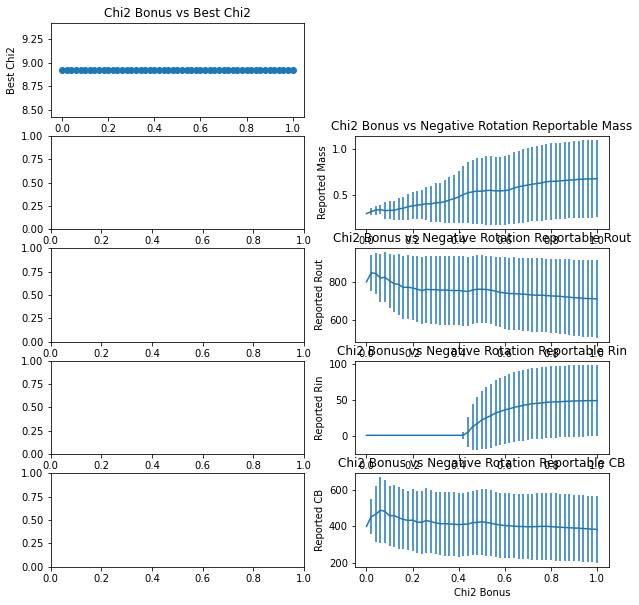

In [202]:
#Chi2 Bonus vs Best Chi2 check
#this is chinky code, takes a very hot minute to run
filename='Per-emb-14.csv'
ThresholdNumCellsOverBeamAreaThreshold=6


#DONE
fig = plt.figure(figsize=(10, 10)) #Setup all the subplots
sub1 = fig.add_subplot(521)
sub3 = fig.add_subplot(523)
sub4 = fig.add_subplot(524)
sub5 = fig.add_subplot(525)
sub6 = fig.add_subplot(526)
sub7 = fig.add_subplot(527)
sub8 = fig.add_subplot(528)
sub9 = fig.add_subplot(529)
sub10 = fig.add_subplot(5, 2, 10)

XAxis=np.linspace(0, 1, 51) #Setup the ThresholdBeamAreaRatio tests

YAxisChi2=[] #omg lots of variables
YAxisPosMass=[]
YAxisErrPosMass=[]
YAxisNegMass=[]
YAxisErrNegMass=[]
YAxisPosRout=[]
YAxisErrPosRout=[]
YAxisNegRout=[]
YAxisErrNegRout=[]
YAxisPosRin=[]
YAxisErrPosRin=[]
YAxisNegRin=[]
YAxisErrNegRin=[]
YAxisPosCB=[]
YAxisErrPosCB=[]
YAxisNegCB=[]
YAxisErrNegCB=[]

for i in XAxis:
    YAxisChi2.append(Reportables(filename, ThresholdNumCellsOverBeamAreaThreshold, i, verbose=False)[8])
    
    YAxisPosMass.append(Reportables(filename, ThresholdNumCellsOverBeamAreaThreshold, i, verbose=False)[0].n)
    YAxisErrPosMass.append(Reportables(filename, ThresholdNumCellsOverBeamAreaThreshold, i, verbose=False)[0].s)
    YAxisNegMass.append(Reportables(filename, ThresholdNumCellsOverBeamAreaThreshold, i, verbose=False)[4].n)
    YAxisErrNegMass.append(Reportables(filename, ThresholdNumCellsOverBeamAreaThreshold, i, verbose=False)[4].s)
    
    YAxisPosRout.append(Reportables(filename, ThresholdNumCellsOverBeamAreaThreshold, i, verbose=False)[1].n)
    YAxisErrPosRout.append(Reportables(filename, ThresholdNumCellsOverBeamAreaThreshold, i, verbose=False)[1].s)
    YAxisNegRout.append(Reportables(filename, ThresholdNumCellsOverBeamAreaThreshold, i, verbose=False)[5].n)
    YAxisErrNegRout.append(Reportables(filename, ThresholdNumCellsOverBeamAreaThreshold, i, verbose=False)[5].s)
    
    YAxisPosRin.append(Reportables(filename, ThresholdNumCellsOverBeamAreaThreshold, i, verbose=False)[2].n)
    YAxisErrPosRin.append(Reportables(filename, ThresholdNumCellsOverBeamAreaThreshold, i, verbose=False)[2].s)
    YAxisNegRin.append(Reportables(filename, ThresholdNumCellsOverBeamAreaThreshold, i, verbose=False)[6].n)
    YAxisErrNegRin.append(Reportables(filename, ThresholdNumCellsOverBeamAreaThreshold, i, verbose=False)[6].s)
    
    YAxisPosCB.append(Reportables(filename, ThresholdNumCellsOverBeamAreaThreshold, i, verbose=False)[3].n)
    YAxisErrPosCB.append(Reportables(filename, ThresholdNumCellsOverBeamAreaThreshold, i, verbose=False)[3].s)
    YAxisNegCB.append(Reportables(filename, ThresholdNumCellsOverBeamAreaThreshold, i, verbose=False)[7].n)
    YAxisErrNegCB.append(Reportables(filename, ThresholdNumCellsOverBeamAreaThreshold, i, verbose=False)[7].s)
    
    
    
    
    
sub1.scatter(XAxis, YAxisChi2)
sub1.set_title('Chi2 Bonus vs Best Chi2')
sub1.set_xlabel('Chi2 Bonus')
sub1.set_ylabel('Best Chi2')

# sub3.errorbar(XAxis, YAxisPosMass, yerr=YAxisErrPosMass)
# sub3.set_title('Chi2 Bonus vs Positive Rotation Reportable Mass')
# sub3.set_xlabel('Chi2 Bonus')
# sub3.set_ylabel('Reported Mass')


sub4.errorbar(XAxis, YAxisNegMass, yerr=YAxisErrNegMass)
sub4.set_title('Chi2 Bonus vs Negative Rotation Reportable Mass')
sub4.set_xlabel('Chi2 Bonus')
sub4.set_ylabel('Reported Mass')


# sub5.errorbar(XAxis, YAxisPosRout, yerr=YAxisErrPosRout)
# sub5.set_title('Chi2 Bonus vs Positive Rotation Reportable Rout')
# sub5.set_xlabel('Chi2 Bonus')
# sub5.set_ylabel('Reported Rout')


sub6.errorbar(XAxis, YAxisNegRout, yerr=YAxisErrNegRout)
sub6.set_title('Chi2 Bonus vs Negative Rotation Reportable Rout')
sub6.set_xlabel('Chi2 Bonus')
sub6.set_ylabel('Reported Rout')


# sub7.errorbar(XAxis, YAxisPosRin, yerr=YAxisErrPosRin)
# sub7.set_title('Chi2 Bonus vs Positive Rotation Reportable Rin')
# sub7.set_xlabel('Chi2 Bonus')
# sub7.set_ylabel('Reported Rin')


sub8.errorbar(XAxis, YAxisNegRin, yerr=YAxisErrNegRin)
sub8.set_title('Chi2 Bonus vs Negative Rotation Reportable Rin')
sub8.set_xlabel('Chi2 Bonus')
sub8.set_ylabel('Reported Rin')


# sub9.errorbar(XAxis, YAxisPosCB, yerr=YAxisErrPosCB)
# sub9.set_title('Chi2 Bonus vs Negative Rotation Reportable CB')
# sub9.set_xlabel('Chi2 Bonus')
# sub9.set_ylabel('Reported CB')


sub10.errorbar(XAxis, YAxisNegCB, yerr=YAxisErrNegCB)
sub10.set_title('Chi2 Bonus vs Negative Rotation Reportable CB')
sub10.set_xlabel('Chi2 Bonus')
sub10.set_ylabel('Reported CB')


In [20]:
Reportables('B5-IRS1_NewBatch.csv', 20, .75)

Best Chi2: 6.7434
Chi2 Bonus: 0.75
So we are allowing models with chi2 less than: 11.80095
With a BeamAreaThreshold over: 20
---------------------------------------------
Negative Models Used: 0
    Negatives Keplerian Models: 0
    Negatives IRE Models: 0
    Negatives Blended Models: 0

Negative Mass: nan+/-nan
Negative Rout:  nan(nan)
Negative Rin:  nan(nan)
Negative CB:  nan(nan)
---------------------------------------------
Positive Models Used: 789
    Positives Keplerian Models: 55
    Positives IRE Models: 2
    Positives Blended Models: 732

Positive Mass: 0.61+/-0.24
Positive Rout: 710.1(231.2)
Positive Rin: 0.253(5.028)
Positive CB: 359.0(249.6)


C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\andre\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(0.6057034220532319+/-0.23551667603472165,
 710.1394169835235+/-231.15647059132445,
 0.2534854245880862+/-5.0283483966735405,
 358.99873257287703+/-249.641337142017,
 nan+/-nan,
 nan+/-nan,
 nan+/-nan,
 nan+/-nan,
 6.7434)

In [10]:
np.average(np.linspace(0.1, 1.5, 15))

0.8

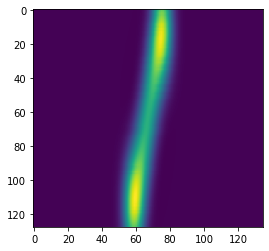

In [9]:
pvdata = fits.getdata('Per-emb-14-Vsys7.63_LineC18O_21_Pix0.054as-0.041666860312837kmps_D300M1.2CB200.I71PA16Rot1Rout200.Rin100._IRE-T0Flare30Nprof-1.5Tprof0..fits')
plt.imshow(pvdata)

In [161]:
glob.glob('../../Per14PV/*Per-emb-14-Vsys7.63_LineC18O_21_Pix0.054as-0.041666860312837kmps_D300M1.2CB200.I71PA16Rot1Rout200.Rin100._IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW2.09_Beam0.538x0.383PA-20.25_PV-PA16deg-CentRA0.Dec0..fits')

['../../Per14PV\\Per-emb-14-Vsys7.63_LineC18O_21_Pix0.054as-0.041666860312837kmps_D300M1.2CB200.I71PA16Rot1Rout200.Rin100._IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW2.09_Beam0.538x0.383PA-20.25_PV-PA16deg-CentRA0.Dec0..fits']

In [83]:
glob.glob('Per14PV/Per-emb-14-Vsys763_LineC18O_21_Pix0054as-0041666860312837kmps_D300M03CB800I71PA16Rot-1Rout800Rin1.fits')

['Per14PV/Per-emb-14-Vsys763_LineC18O_21_Pix0054as-0041666860312837kmps_D300M03CB800I71PA16Rot-1Rout800Rin1.fits']

In [8]:
len('Per-emb-14-Vsys7.63_LineC18O_21_Pix0.054as-0.041666860312837kmps_D300M1.2CB200.I71PA16Rot1Rout200.Rin100._IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW2.09_Beam0.538x0.383PA-20.25_PV-PA16deg-CentRA0.Dec0..fits')

228

In [6]:
len('_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW1.0_Beam0.538x0.383PA-20.25_PV-PA50deg-CentRA0.Dec0..fits')

122

In [102]:
# File paths
source_fits = "Per14PV/Per-emb-14-Vsys77_LineC18O_21_Pix0054as041666860312837kmps_D300M01CB100I71PA16Rot1Rout400Rin1.fits"  # File with the header you want to copy
target_fits = "PerEmb14PVAvgExample.fits"  # File whose header you want to replace
output_fits = "PerEmb14PVAvgExample2.fits"  # New file with the updated header

# Open the source FITS file and extract the header
with fits.open(source_fits) as src_hdul:
    source_header = src_hdul[0].header  # Assuming primary HDU

# Open the target FITS file, update the header, and save
with fits.open(target_fits, mode='update') as tgt_hdul:
    tgt_hdul[0].header = source_header  # Copy the header
    tgt_hdul.writeto(output_fits, overwrite=True)  # Save as new file

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'PerEmb14PVAvgExample.fits'

[[2.8 3.  nan]
 [2.8 nan 3.5]]


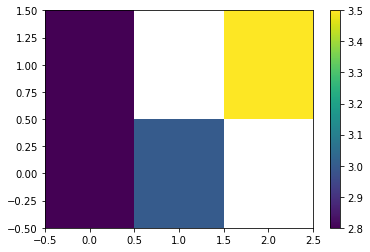

[ 5  5  5  5  5  6  6  6  6  6  9 14 14]


In [33]:
#showing off GTC issue
from scipy.stats import binned_statistic_2d

# fig = plt.figure(figsize=(5, 5))
# sub1 = fig.add_subplot(111)
# sub1.scatter(1, 1, alpha = 0.2, color = 'green', marker = 's', s = 1000)
# sub1.scatter(1, 1, alpha = 0.2, color = 'green', marker = 's', s = 1000)
# sub1.scatter(1, 1, alpha = 0.2, color = 'green', marker = 's', s = 1000)
# sub1.scatter(1, 1, alpha = 0.2, color = 'green', marker = 's', s = 1000)
# sub1.scatter(1, 1, alpha = 0.2, color = 'red', marker = 's', s = 1000)

# sub2 = fig.add_subplot(121)
# sub2.scatter(1, 1, alpha = 0.2, color = 'red', marker = 's', s = 1000)
# sub2.scatter(1, 1, alpha = 0.2, color = 'green', marker = 's', s = 1000)
# sub2.scatter(1, 1, alpha = 0.2, color = 'green', marker = 's', s = 1000)
# sub2.scatter(1, 1, alpha = 0.2, color = 'green', marker = 's', s = 1000)
# sub2.scatter(1, 1, alpha = 0.2, color = 'green', marker = 's', s = 1000)

#Trying out some order independence code, lets see how it works
x=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3]
y=[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2]
z=[1, 1, 1, 1, 10, 10, 1, 1, 1, 1, 3, 3, 4]
stat, xedges, yedges, binnumber = binned_statistic_2d(
    x, y, z, statistic='mean', bins = (len(np.unique(x)), len(np.unique(y))))
#This function produces an image, size set by bins(which can be a tuple!)
#It does remove all ordering issues we have
#it works the same with uneven sized splats, yay!

print(stat.T) #huh it's upside down compared to the image. Weird
plt.imshow(stat.T, origin='lower', cmap='viridis', aspect='auto')
plt.colorbar()
plt.show()
print(binnumber)

#In short, we can create order independent images where multiple data points are at the same location
#which is what our 2d flattening of 4d grid search data does
#I need to actually impliment this in the GTC maker but this example demo I think showcases everything we need to do

In [20]:
#tiny black markers(points) with transparency
#see what plots look like

In [24]:
#Some quick code to find the best models for PV diagram making
Table = CSVToDataframe('B5-IRS1_NewBatch.csv')

Table=Table.loc[Table['RotationDirection'] == 1] #Filter out rotation direction

ThresholdNumCellsOverBeamAreaThreshold = 6
Table=Table.loc[Table['ThresholdNumCellsOverBeamArea'] >= float(ThresholdNumCellsOverBeamAreaThreshold)] 
Table.reindex() #This takes care of our threshold value, only keeps good models

#Split into our 3 groups
IREOnly = Table.loc[Table['IRE?'] == True] 
KeplerianOnly = Table.loc[Table['Keplerian?'] == True]
Blended = Table.loc[Table['Blended?'] == True]

print('IREOnly')
print(IREOnly.loc[IREOnly['Threshold Reduced Chi2'].idxmin(), 'Cube Name'])
print('----------------------')
print('Blended')
print(Blended.loc[Blended['Threshold Reduced Chi2'].idxmin(), 'Cube Name'])
print('----------------------')
print('KeplerianOnly')
print(KeplerianOnly.loc[KeplerianOnly['Threshold Reduced Chi2'].idxmin(), 'Cube Name'])






IREOnly
B5-IRS1-Vsys10.198_LineC18O_21_Pix0.054as-0.041666749639012kmps_D300M1.3CB300.I29PA168Rot1Rout1000.Rin300._IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW1.64_Beam0.448x0.294PA-20.291.fits
----------------------
Blended
B5-IRS1-Vsys10.198_LineC18O_21_Pix0.054as-0.041666749639012kmps_D300M1.5CB350.I29PA168Rot1Rout1000.Rin300._IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW1.64_Beam0.448x0.294PA-20.291.fits
----------------------
KeplerianOnly
B5-IRS1-Vsys10.198_LineC18O_21_Pix0.054as-0.041666749639012kmps_D300M0.1CB400.I29PA168Rot1Rout400.Rin300._IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW1.64_Beam0.448x0.294PA-20.291.fits
